# Directory
<div>
    <ul>
        <li><a href='#image-preprocess'>image preprocess</li>
        <li><a href='#stack-4-frame'>stack 4 frame</li>
        <li><a href='#DQN-Network'>DQN Network</li>
        <li><a href='#replay-buffer'>replay buffer</li>
        <li><a href='#Q-learning'>Q-learning</li>
        <li><a href='#start-training'>start training</li>
    </ul>
</div>

In [1]:
import tensorflow as tf
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from skimage import color
from skimage import transform
import gym

In [2]:
env=gym.make('SpaceInvaders-v0')

In [3]:
print(env.observation_space)
print(env.action_space)

Box(210, 160, 3)
Discrete(6)


# image preprocess

In [4]:
def image_preprocess(image):
    '''
    (210,160,3)->(110,84)
    '''
    image=color.rgb2gray(image)
    image=image[8:-12,4:-12]
    image=transform.resize(image,(110,84))
    return image

state shape:  (210, 160, 3)
after preprocess:  (110, 84)


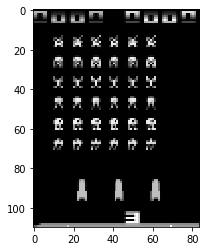

[[0.00337809 0.00337809 0.00337809 0.00337809 0.00337809]
 [0.37218825 0.3721871  0.37153391 0.37134373 0.37153391]
 [0.33682738 0.33637054 0.0771591  0.00168905 0.0771591 ]
 [0.23074475 0.23043022 0.05196158 0.         0.05196158]
 [0.12466212 0.12449219 0.02807276 0.         0.02807276]]


In [5]:
state=env.reset()
print('state shape: ',state.shape)
state=image_preprocess(state)
print('after preprocess: ',state.shape)
plt.imshow(state,cmap='gray')
plt.show()
print(state[:5,:5])

# stack 4 frame

In [6]:
deque_stacked_frames=deque(maxlen=4)
def stack_frame(state,is_start=False):
    '''
    input: (210,160,3) state
    return (110,84,4) stacked frame
    '''
    state=image_preprocess(state)
    
    if is_start:
        for i in range(4):
            deque_stacked_frames.append(state)
    else:
        deque_stacked_frames.append(state)
    
    return np.stack(deque_stacked_frames,axis=-1)

# DQN Network

In [7]:
class DQN():    
    def __init__(self,input_size=(110,84,4),action_size=6,learning_rate=0.0002):
        '''
        return output_layer graph
        '''
        with tf.variable_scope('DQN_Network'):
            input_layer=tf.placeholder(tf.float32,[None,*input_size],name='input_layer')
            actions=tf.placeholder(tf.float32,[None,action_size],name='action_1d_tensor')
            targets=tf.placeholder(tf.float32,[None,],name='target')
            
            conv1=tf.keras.layers.Conv2D(32,kernel_size=(8,8),strides=(4,4),padding='valid',name='conv1')(input_layer)
            elu1=tf.keras.activations.elu(conv1)
            conv2=tf.keras.layers.Conv2D(64,kernel_size=(4,4),strides=(2,2),padding='valid',name='conv2')(elu1)
            elu2=tf.keras.activations.elu(conv2)
            conv3=tf.keras.layers.Conv2D(128,kernel_size=(4,4),strides=(2,2),padding='valid',name='conv3')(elu2)
            elu3=tf.keras.activations.elu(conv3)
            flatten=tf.keras.layers.Flatten(name='flatten')(elu3)
            fc1=tf.keras.layers.Dense(512,activation='elu',name='fc1')(flatten)
            output_layer=tf.keras.layers.Dense(action_size,activation='linear')(fc1)
        
            predicts=tf.reduce_sum(tf.multiply(output_layer,actions),axis=1)
            loss=tf.reduce_mean(tf.square(predicts-targets))
            optimizer=tf.train.AdamOptimizer(learning_rate).minimize(loss)
        
        self.input=input_layer
        self.actions=actions
        self.targets=targets
        
        self.output=output_layer
        self.loss=loss
        self.optimizer=optimizer

# replay buffer

(state,action,reward,next_state,done)  
(state,action,reward,next_state,done)  
(state,action,reward,next_state,done)  
...  
...  

In [8]:
replay_buffer_size=20000

In [9]:
replay_buffer=deque(maxlen=replay_buffer_size)
def samplebatch(batch_size):
    '''
    return a list of experience
    '''
    max_len=len(replay_buffer)
    index=np.random.choice(max_len,batch_size,replace=False)
    return [replay_buffer[i] for i in index]

In [10]:
'''
init with a batchsize
state & next_state shape are both (110,84,4) 
'''
done=1
for i in range(64):
    if done==1:
        state=env.reset()
        state=stack_frame(state,is_start=True)
    
    action=np.random.randint(6)
    next_state,reward,done, _ =env.step(action)
    next_state=stack_frame(next_state)
    
    replay_buffer.append((state,action,reward,next_state,done))
    
    state=next_state

# Q-learning
__<font color='#ff0000'>Q(s,a)=在s下做a，所得到的直到end的reward總和</font>__  

* **For** episode to max_episode **do** 
    * Make new episode
    * Set step to 0
    * Observe the first state $s_0$
    <br><br>
    * **While** step < max_steps **do**:
        * Increase decay_rate
        * With $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
        * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
        * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
        * Sample random mini-batch from $D$: $<s, a, r, s'>$
        * Set $\hat{Q} = r$ if the episode ends at $s+1$, otherwise set $\hat{Q} = r + \gamma \max_{a'}{Q(s', a')}$
        * Make a gradient descent step with loss $(\hat{Q} - Q(s, a))^2$
    * **endfor**
    <br><br>
* **endfor**

In [11]:
def choose_action(network,max_epsilon,min_epsilon,decay_rate,state,step,sess):
    explore_prob=min_epsilon+(max_epsilon-min_epsilon)*np.exp(-decay_rate*step)
    if np.random.rand()<explore_prob:  #explore
        action=np.random.choice(6)
    else:  #exploit
        action=sess.run(network.output,feed_dict={network.input: np.expand_dims(state,axis=0)})
        action=np.argmax(action)
    return action,explore_prob

In [12]:
def apart_mini_batch(mini_batch):
    mb_state=np.array([batch[0] for batch in mini_batch])
    mb_action=np.array([batch[1] for batch in mini_batch])
    mb_reward=np.array([batch[2] for batch in mini_batch])
    mb_next_state=np.array([batch[3] for batch in mini_batch])
    mb_done=np.array([batch[4] for batch in mini_batch])
    
    return mb_state,mb_action,mb_reward,mb_next_state,mb_done

In [13]:
def train(network,max_episode=10000,max_steps=10000,batch_size=64,max_epsilon=1.0,min_epsilon=0.1,decay_rate=1e-5,gamma=0.9):
    decay_step=1
    with tf.Session() as sess:
        init=tf.global_variables_initializer()
        sess.run(init)
        for episode in range(max_episode):
            episode_total_reward=0
            state=env.reset()
            state=stack_frame(state,is_start=True)
            for step in range(max_steps):
                
                #choose action
                action,explore_prob=choose_action(network,max_epsilon,min_epsilon,decay_rate,state,decay_step,sess)
                decay_step+=1
                
                #env.step()
                next_state,reward,done, _ =env.step(action)
                next_state=stack_frame(next_state)
                episode_total_reward+=reward
                
                env.render()
                
                #store this experience
                replay_buffer.append((state,action,reward,next_state,done))
                
                #sample mini-batch
                mini_batch=samplebatch(batch_size)
                mb_state,mb_action,mb_reward,mb_next_state,mb_done=apart_mini_batch(mini_batch)
    
                #set Q_hat
                mb_target=gamma*np.max(sess.run(network.output,feed_dict={network.input: mb_next_state}),axis=1)+mb_reward
                mb_target[mb_done==1]=mb_reward[mb_done==1]
                
                #one hot encoding
                mb_action_onehot=np.zeros((batch_size,6))
                for i in range(batch_size):
                    mb_action_onehot[i,mb_action[i]]=1.
                
                #gradient descent
                loss, _ =sess.run([network.loss,network.optimizer],feed_dict={network.input: mb_state,network.actions: mb_action_onehot,network.targets: mb_target})
                
                
                if done or step==max_steps:
                    print('Episode{}   Total Reward: {}  loss: {:.2f}  explore_prob: {:.2f}'.format(episode,episode_total_reward,loss,explore_prob))
                    break     

# start training

In [14]:
tf.reset_default_graph()
dqn=DQN(input_size=(110,84,4),action_size=6,learning_rate=0.0002)
train(dqn,max_episode=10000,max_steps=10000,batch_size=64,max_epsilon=1.0,min_epsilon=0.1,decay_rate=1e-5,gamma=0.9)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Episode0   Total Reward: 90.0  loss: 9.58  explore_prob: 0.99
Episode1   Total Reward: 65.0  loss: 0.47  explore_prob: 0.99
Episode2   Total Reward: 75.0  loss: 0.02  explore_prob: 0.99
Episode3   Total Reward: 325.0  loss: 11.10  explore_prob: 0.98
Episode4   Total Reward: 155.0  loss: 1.60  explore_prob: 0.97
Episode5   Total Reward: 365.0  loss: 0.06  explore_prob: 0.96
Episode6   Total Reward: 110.0  loss: 8.22  explore_prob: 0.96
Episode7   Total Reward: 55.0  loss: 0.42  explore_prob: 0.95
Episode8   Total Reward: 110.0  loss: 3.48  explore_prob: 0.95
Episode9   Total Reward: 125.0  loss: 1.50  explore_prob: 0.94
Episode10   Total Reward: 210.0  loss: 3.49  explore_prob: 0.93
Episode11   Total Reward: 250.0  loss: 0.05  explore_prob: 0.93
Episode12   Total Reward: 155.0  loss: 3.86  explore_prob: 0.92
Episode13   Total Reward: 270.0  loss: 6.58  explore_prob: 0.91

Episode123   Total Reward: 265.0  loss: 6.92  explore_prob: 0.46
Episode124   Total Reward: 150.0  loss: 6.24  explore_prob: 0.46
Episode125   Total Reward: 315.0  loss: 3.51  explore_prob: 0.46
Episode126   Total Reward: 130.0  loss: 0.06  explore_prob: 0.45
Episode127   Total Reward: 470.0  loss: 13.76  explore_prob: 0.45
Episode128   Total Reward: 325.0  loss: 0.08  explore_prob: 0.44
Episode129   Total Reward: 75.0  loss: 3.47  explore_prob: 0.44
Episode130   Total Reward: 105.0  loss: 13.96  explore_prob: 0.44
Episode131   Total Reward: 30.0  loss: 29.21  explore_prob: 0.44
Episode132   Total Reward: 115.0  loss: 0.38  explore_prob: 0.44
Episode133   Total Reward: 210.0  loss: 0.07  explore_prob: 0.43
Episode134   Total Reward: 400.0  loss: 0.08  explore_prob: 0.43
Episode135   Total Reward: 115.0  loss: 3.46  explore_prob: 0.43
Episode136   Total Reward: 400.0  loss: 0.02  explore_prob: 0.43
Episode137   Total Reward: 20.0  loss: 0.09  explore_prob: 0.42
Episode138   Total Reward

Episode250   Total Reward: 245.0  loss: 20.40  explore_prob: 0.24
Episode251   Total Reward: 105.0  loss: 0.17  explore_prob: 0.23
Episode252   Total Reward: 260.0  loss: 0.08  explore_prob: 0.23
Episode253   Total Reward: 210.0  loss: 13.93  explore_prob: 0.23
Episode254   Total Reward: 240.0  loss: 3.44  explore_prob: 0.23
Episode255   Total Reward: 410.0  loss: 9.12  explore_prob: 0.23
Episode256   Total Reward: 120.0  loss: 0.46  explore_prob: 0.23
Episode257   Total Reward: 135.0  loss: 0.08  explore_prob: 0.23
Episode258   Total Reward: 105.0  loss: 0.05  explore_prob: 0.23
Episode259   Total Reward: 75.0  loss: 4.89  explore_prob: 0.23
Episode260   Total Reward: 105.0  loss: 0.42  explore_prob: 0.23
Episode261   Total Reward: 245.0  loss: 0.42  explore_prob: 0.23
Episode262   Total Reward: 210.0  loss: 0.08  explore_prob: 0.22
Episode263   Total Reward: 80.0  loss: 9.74  explore_prob: 0.22
Episode264   Total Reward: 275.0  loss: 0.06  explore_prob: 0.22
Episode265   Total Reward

Episode377   Total Reward: 380.0  loss: 3.45  explore_prob: 0.15
Episode378   Total Reward: 515.0  loss: 1.72  explore_prob: 0.15
Episode379   Total Reward: 185.0  loss: 0.45  explore_prob: 0.15
Episode380   Total Reward: 80.0  loss: 0.12  explore_prob: 0.15
Episode381   Total Reward: 980.0  loss: 0.10  explore_prob: 0.15
Episode382   Total Reward: 215.0  loss: 0.11  explore_prob: 0.15
Episode383   Total Reward: 260.0  loss: 1.93  explore_prob: 0.15
Episode384   Total Reward: 215.0  loss: 0.06  explore_prob: 0.15
Episode385   Total Reward: 165.0  loss: 13.94  explore_prob: 0.15
Episode386   Total Reward: 135.0  loss: 14.26  explore_prob: 0.15
Episode387   Total Reward: 130.0  loss: 0.40  explore_prob: 0.14
Episode388   Total Reward: 165.0  loss: 0.07  explore_prob: 0.14
Episode389   Total Reward: 245.0  loss: 2.28  explore_prob: 0.14
Episode390   Total Reward: 115.0  loss: 0.08  explore_prob: 0.14
Episode391   Total Reward: 375.0  loss: 0.44  explore_prob: 0.14
Episode392   Total Rewar

Episode504   Total Reward: 240.0  loss: 0.08  explore_prob: 0.12
Episode505   Total Reward: 185.0  loss: 6.88  explore_prob: 0.12
Episode506   Total Reward: 235.0  loss: 1.54  explore_prob: 0.12
Episode507   Total Reward: 140.0  loss: 0.42  explore_prob: 0.12
Episode508   Total Reward: 55.0  loss: 6.16  explore_prob: 0.12
Episode509   Total Reward: 180.0  loss: 0.42  explore_prob: 0.12
Episode510   Total Reward: 220.0  loss: 10.07  explore_prob: 0.12
Episode511   Total Reward: 155.0  loss: 0.07  explore_prob: 0.12
Episode512   Total Reward: 335.0  loss: 0.08  explore_prob: 0.12
Episode513   Total Reward: 180.0  loss: 0.05  explore_prob: 0.12
Episode514   Total Reward: 495.0  loss: 0.13  explore_prob: 0.12
Episode515   Total Reward: 105.0  loss: 13.81  explore_prob: 0.12
Episode516   Total Reward: 215.0  loss: 1.61  explore_prob: 0.11
Episode517   Total Reward: 260.0  loss: 0.05  explore_prob: 0.11
Episode518   Total Reward: 140.0  loss: 1.90  explore_prob: 0.11
Episode519   Total Rewar

Episode630   Total Reward: 380.0  loss: 5.22  explore_prob: 0.11
Episode631   Total Reward: 185.0  loss: 13.02  explore_prob: 0.11
Episode632   Total Reward: 210.0  loss: 0.09  explore_prob: 0.11
Episode633   Total Reward: 120.0  loss: 0.06  explore_prob: 0.11
Episode634   Total Reward: 260.0  loss: 6.14  explore_prob: 0.11
Episode635   Total Reward: 210.0  loss: 1.57  explore_prob: 0.11
Episode636   Total Reward: 105.0  loss: 6.90  explore_prob: 0.10
Episode637   Total Reward: 370.0  loss: 3.50  explore_prob: 0.10
Episode638   Total Reward: 240.0  loss: 19.11  explore_prob: 0.10
Episode639   Total Reward: 515.0  loss: 0.09  explore_prob: 0.10
Episode640   Total Reward: 210.0  loss: 0.09  explore_prob: 0.10
Episode641   Total Reward: 75.0  loss: 9.67  explore_prob: 0.10
Episode642   Total Reward: 120.0  loss: 9.61  explore_prob: 0.10
Episode643   Total Reward: 210.0  loss: 11.10  explore_prob: 0.10
Episode644   Total Reward: 155.0  loss: 4.95  explore_prob: 0.10
Episode645   Total Rewa

Episode756   Total Reward: 170.0  loss: 7.67  explore_prob: 0.10
Episode757   Total Reward: 100.0  loss: 0.06  explore_prob: 0.10
Episode758   Total Reward: 215.0  loss: 0.06  explore_prob: 0.10
Episode759   Total Reward: 240.0  loss: 0.04  explore_prob: 0.10
Episode760   Total Reward: 285.0  loss: 0.10  explore_prob: 0.10
Episode761   Total Reward: 210.0  loss: 0.10  explore_prob: 0.10
Episode762   Total Reward: 75.0  loss: 0.41  explore_prob: 0.10
Episode763   Total Reward: 160.0  loss: 0.05  explore_prob: 0.10
Episode764   Total Reward: 55.0  loss: 0.04  explore_prob: 0.10
Episode765   Total Reward: 250.0  loss: 14.17  explore_prob: 0.10
Episode766   Total Reward: 50.0  loss: 6.54  explore_prob: 0.10
Episode767   Total Reward: 390.0  loss: 0.06  explore_prob: 0.10
Episode768   Total Reward: 15.0  loss: 19.96  explore_prob: 0.10
Episode769   Total Reward: 335.0  loss: 3.41  explore_prob: 0.10
Episode770   Total Reward: 50.0  loss: 0.10  explore_prob: 0.10
Episode771   Total Reward: 2

Episode882   Total Reward: 305.0  loss: 1.56  explore_prob: 0.10
Episode883   Total Reward: 210.0  loss: 13.95  explore_prob: 0.10
Episode884   Total Reward: 410.0  loss: 0.09  explore_prob: 0.10
Episode885   Total Reward: 110.0  loss: 0.07  explore_prob: 0.10
Episode886   Total Reward: 15.0  loss: 13.97  explore_prob: 0.10
Episode887   Total Reward: 240.0  loss: 0.41  explore_prob: 0.10
Episode888   Total Reward: 460.0  loss: 10.43  explore_prob: 0.10
Episode889   Total Reward: 185.0  loss: 0.09  explore_prob: 0.10
Episode890   Total Reward: 210.0  loss: 7.60  explore_prob: 0.10
Episode891   Total Reward: 240.0  loss: 5.30  explore_prob: 0.10
Episode892   Total Reward: 145.0  loss: 0.08  explore_prob: 0.10
Episode893   Total Reward: 180.0  loss: 3.83  explore_prob: 0.10
Episode894   Total Reward: 445.0  loss: 0.45  explore_prob: 0.10
Episode895   Total Reward: 105.0  loss: 1.56  explore_prob: 0.10
Episode896   Total Reward: 240.0  loss: 0.09  explore_prob: 0.10
Episode897   Total Rewa

Episode1008   Total Reward: 130.0  loss: 15.57  explore_prob: 0.10
Episode1009   Total Reward: 145.0  loss: 0.07  explore_prob: 0.10
Episode1010   Total Reward: 215.0  loss: 0.08  explore_prob: 0.10
Episode1011   Total Reward: 150.0  loss: 0.08  explore_prob: 0.10
Episode1012   Total Reward: 285.0  loss: 12.98  explore_prob: 0.10
Episode1013   Total Reward: 200.0  loss: 3.82  explore_prob: 0.10
Episode1014   Total Reward: 160.0  loss: 0.07  explore_prob: 0.10
Episode1015   Total Reward: 395.0  loss: 0.08  explore_prob: 0.10
Episode1016   Total Reward: 150.0  loss: 6.44  explore_prob: 0.10
Episode1017   Total Reward: 410.0  loss: 1.57  explore_prob: 0.10
Episode1018   Total Reward: 150.0  loss: 0.78  explore_prob: 0.10
Episode1019   Total Reward: 345.0  loss: 3.87  explore_prob: 0.10
Episode1020   Total Reward: 245.0  loss: 3.83  explore_prob: 0.10
Episode1021   Total Reward: 260.0  loss: 0.41  explore_prob: 0.10
Episode1022   Total Reward: 235.0  loss: 14.32  explore_prob: 0.10
Episode

Episode1132   Total Reward: 300.0  loss: 0.10  explore_prob: 0.10
Episode1133   Total Reward: 350.0  loss: 1.55  explore_prob: 0.10
Episode1134   Total Reward: 155.0  loss: 0.42  explore_prob: 0.10
Episode1135   Total Reward: 340.0  loss: 6.50  explore_prob: 0.10
Episode1136   Total Reward: 300.0  loss: 0.07  explore_prob: 0.10
Episode1137   Total Reward: 165.0  loss: 0.43  explore_prob: 0.10
Episode1138   Total Reward: 650.0  loss: 0.44  explore_prob: 0.10
Episode1139   Total Reward: 165.0  loss: 0.12  explore_prob: 0.10
Episode1140   Total Reward: 330.0  loss: 9.74  explore_prob: 0.10
Episode1141   Total Reward: 405.0  loss: 34.63  explore_prob: 0.10
Episode1142   Total Reward: 370.0  loss: 0.46  explore_prob: 0.10
Episode1143   Total Reward: 265.0  loss: 3.83  explore_prob: 0.10
Episode1144   Total Reward: 185.0  loss: 6.32  explore_prob: 0.10
Episode1145   Total Reward: 215.0  loss: 0.08  explore_prob: 0.10
Episode1146   Total Reward: 220.0  loss: 1.88  explore_prob: 0.10
Episode11

Episode1256   Total Reward: 285.0  loss: 9.51  explore_prob: 0.10
Episode1257   Total Reward: 110.0  loss: 0.14  explore_prob: 0.10
Episode1258   Total Reward: 120.0  loss: 0.09  explore_prob: 0.10
Episode1259   Total Reward: 240.0  loss: 3.87  explore_prob: 0.10
Episode1260   Total Reward: 220.0  loss: 6.06  explore_prob: 0.10
Episode1261   Total Reward: 110.0  loss: 6.20  explore_prob: 0.10
Episode1262   Total Reward: 380.0  loss: 6.12  explore_prob: 0.10
Episode1263   Total Reward: 245.0  loss: 1.53  explore_prob: 0.10
Episode1264   Total Reward: 180.0  loss: 0.08  explore_prob: 0.10
Episode1265   Total Reward: 100.0  loss: 0.08  explore_prob: 0.10
Episode1266   Total Reward: 180.0  loss: 3.52  explore_prob: 0.10
Episode1267   Total Reward: 210.0  loss: 13.96  explore_prob: 0.10
Episode1268   Total Reward: 310.0  loss: 6.48  explore_prob: 0.10
Episode1269   Total Reward: 185.0  loss: 0.11  explore_prob: 0.10
Episode1270   Total Reward: 155.0  loss: 0.06  explore_prob: 0.10
Episode12

Episode1380   Total Reward: 460.0  loss: 0.09  explore_prob: 0.10
Episode1381   Total Reward: 435.0  loss: 0.12  explore_prob: 0.10
Episode1382   Total Reward: 315.0  loss: 6.12  explore_prob: 0.10
Episode1383   Total Reward: 250.0  loss: 0.10  explore_prob: 0.10
Episode1384   Total Reward: 75.0  loss: 2.27  explore_prob: 0.10
Episode1385   Total Reward: 120.0  loss: 6.10  explore_prob: 0.10
Episode1386   Total Reward: 135.0  loss: 0.21  explore_prob: 0.10
Episode1387   Total Reward: 295.0  loss: 0.44  explore_prob: 0.10
Episode1388   Total Reward: 210.0  loss: 14.38  explore_prob: 0.10
Episode1389   Total Reward: 210.0  loss: 10.47  explore_prob: 0.10
Episode1390   Total Reward: 185.0  loss: 3.09  explore_prob: 0.10
Episode1391   Total Reward: 325.0  loss: 15.29  explore_prob: 0.10
Episode1392   Total Reward: 410.0  loss: 0.08  explore_prob: 0.10
Episode1393   Total Reward: 155.0  loss: 9.06  explore_prob: 0.10
Episode1394   Total Reward: 285.0  loss: 0.06  explore_prob: 0.10
Episode1

Episode1505   Total Reward: 180.0  loss: 3.46  explore_prob: 0.10
Episode1506   Total Reward: 290.0  loss: 15.73  explore_prob: 0.10
Episode1507   Total Reward: 120.0  loss: 1.54  explore_prob: 0.10
Episode1508   Total Reward: 205.0  loss: 0.42  explore_prob: 0.10
Episode1509   Total Reward: 1140.0  loss: 0.17  explore_prob: 0.10
Episode1510   Total Reward: 215.0  loss: 0.38  explore_prob: 0.10
Episode1511   Total Reward: 105.0  loss: 0.08  explore_prob: 0.10
Episode1512   Total Reward: 260.0  loss: 0.08  explore_prob: 0.10
Episode1513   Total Reward: 205.0  loss: 27.40  explore_prob: 0.10
Episode1514   Total Reward: 30.0  loss: 9.87  explore_prob: 0.10
Episode1515   Total Reward: 210.0  loss: 1.92  explore_prob: 0.10
Episode1516   Total Reward: 300.0  loss: 1.59  explore_prob: 0.10
Episode1517   Total Reward: 380.0  loss: 622.55  explore_prob: 0.10
Episode1518   Total Reward: 265.0  loss: 0.82  explore_prob: 0.10
Episode1519   Total Reward: 335.0  loss: 0.46  explore_prob: 0.10
Episod

Episode1630   Total Reward: 130.0  loss: 1.54  explore_prob: 0.10
Episode1631   Total Reward: 70.0  loss: 0.06  explore_prob: 0.10
Episode1632   Total Reward: 175.0  loss: 0.04  explore_prob: 0.10
Episode1633   Total Reward: 55.0  loss: 6.19  explore_prob: 0.10
Episode1634   Total Reward: 50.0  loss: 0.69  explore_prob: 0.10
Episode1635   Total Reward: 155.0  loss: 0.07  explore_prob: 0.10
Episode1636   Total Reward: 180.0  loss: 622.94  explore_prob: 0.10
Episode1637   Total Reward: 95.0  loss: 0.06  explore_prob: 0.10
Episode1638   Total Reward: 325.0  loss: 0.05  explore_prob: 0.10
Episode1639   Total Reward: 315.0  loss: 0.07  explore_prob: 0.10
Episode1640   Total Reward: 140.0  loss: 0.07  explore_prob: 0.10
Episode1641   Total Reward: 410.0  loss: 0.11  explore_prob: 0.10
Episode1642   Total Reward: 150.0  loss: 14.14  explore_prob: 0.10
Episode1643   Total Reward: 250.0  loss: 17.26  explore_prob: 0.10
Episode1644   Total Reward: 10.0  loss: 0.42  explore_prob: 0.10
Episode1645

Episode1755   Total Reward: 190.0  loss: 9.53  explore_prob: 0.10
Episode1756   Total Reward: 145.0  loss: 6.12  explore_prob: 0.10
Episode1757   Total Reward: 440.0  loss: 0.45  explore_prob: 0.10
Episode1758   Total Reward: 250.0  loss: 0.06  explore_prob: 0.10
Episode1759   Total Reward: 130.0  loss: 0.21  explore_prob: 0.10
Episode1760   Total Reward: 265.0  loss: 0.08  explore_prob: 0.10
Episode1761   Total Reward: 380.0  loss: 9.73  explore_prob: 0.10
Episode1762   Total Reward: 225.0  loss: 0.07  explore_prob: 0.10
Episode1763   Total Reward: 105.0  loss: 4.91  explore_prob: 0.10
Episode1764   Total Reward: 245.0  loss: 9.47  explore_prob: 0.10
Episode1765   Total Reward: 175.0  loss: 1.55  explore_prob: 0.10
Episode1766   Total Reward: 160.0  loss: 10.15  explore_prob: 0.10
Episode1767   Total Reward: 280.0  loss: 1.53  explore_prob: 0.10
Episode1768   Total Reward: 120.0  loss: 0.43  explore_prob: 0.10
Episode1769   Total Reward: 115.0  loss: 0.45  explore_prob: 0.10
Episode17

Episode1880   Total Reward: 260.0  loss: 12.51  explore_prob: 0.10
Episode1881   Total Reward: 80.0  loss: 0.09  explore_prob: 0.10
Episode1882   Total Reward: 85.0  loss: 14.06  explore_prob: 0.10
Episode1883   Total Reward: 160.0  loss: 0.08  explore_prob: 0.10
Episode1884   Total Reward: 520.0  loss: 0.54  explore_prob: 0.10
Episode1885   Total Reward: 430.0  loss: 3.36  explore_prob: 0.10
Episode1886   Total Reward: 215.0  loss: 13.69  explore_prob: 0.10
Episode1887   Total Reward: 390.0  loss: 0.44  explore_prob: 0.10
Episode1888   Total Reward: 480.0  loss: 6.17  explore_prob: 0.10
Episode1889   Total Reward: 240.0  loss: 5.06  explore_prob: 0.10
Episode1890   Total Reward: 225.0  loss: 0.09  explore_prob: 0.10
Episode1891   Total Reward: 120.0  loss: 9.38  explore_prob: 0.10
Episode1892   Total Reward: 180.0  loss: 3.46  explore_prob: 0.10
Episode1893   Total Reward: 150.0  loss: 3.75  explore_prob: 0.10
Episode1894   Total Reward: 325.0  loss: 4.39  explore_prob: 0.10
Episode18

Episode2004   Total Reward: 165.0  loss: 0.07  explore_prob: 0.10
Episode2005   Total Reward: 155.0  loss: 9.55  explore_prob: 0.10
Episode2006   Total Reward: 355.0  loss: 13.90  explore_prob: 0.10
Episode2007   Total Reward: 125.0  loss: 0.06  explore_prob: 0.10
Episode2008   Total Reward: 215.0  loss: 1.50  explore_prob: 0.10
Episode2009   Total Reward: 75.0  loss: 23.23  explore_prob: 0.10
Episode2010   Total Reward: 415.0  loss: 1.49  explore_prob: 0.10
Episode2011   Total Reward: 180.0  loss: 0.04  explore_prob: 0.10
Episode2012   Total Reward: 260.0  loss: 6.81  explore_prob: 0.10
Episode2013   Total Reward: 260.0  loss: 0.07  explore_prob: 0.10
Episode2014   Total Reward: 750.0  loss: 0.42  explore_prob: 0.10
Episode2015   Total Reward: 155.0  loss: 0.42  explore_prob: 0.10
Episode2016   Total Reward: 530.0  loss: 0.42  explore_prob: 0.10
Episode2017   Total Reward: 210.0  loss: 6.18  explore_prob: 0.10
Episode2018   Total Reward: 375.0  loss: 0.04  explore_prob: 0.10
Episode20

KeyboardInterrupt: 

In [ ]:
len(replay_buffer)